<a href="https://colab.research.google.com/github/DeeperSense/BTS-2023/blob/master/sonavision/sonavision-bts-tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
!curl https://cloud.dfki.de/owncloud/index.php/s/jyTsJfSR6fCjMoR/download --output data.zip
!unzip data.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1074M    0 1074M    0     0  17.9M      0 --:--:--  0:00:59 --:--:-- 17.7M
Archive:  data.zip
   creating: BTS23/
   creating: BTS23/indoor-pool/
   creating: BTS23/indoor-pool/models/
   creating: BTS23/indoor-pool/models/assets/
 extracting: BTS23/indoor-pool/models/saved_model.pb  
   creating: BTS23/indoor-pool/models/variables/
 extracting: BTS23/indoor-pool/models/variables/variables.data-00000-of-00001  
 extracting: BTS23/indoor-pool/models/variables/variables.index  
   creating: BTS23/indoor-pool/test-data/
 extracting: BTS23/indoor-pool/test-data/0-0516.png  
 extracting: BTS23/indoor-pool/test-data/0-0945.png  
 extracting: BTS23/indoor-pool/test-data/0-1713.png  
 extracting: BTS23/indoor-pool/test-data/100-0516.png  
 extracting: BTS23/indoor-pool/test-data/100-0945.png  
 extracting: BTS23/indoor-pool/test-data/

In [3]:
dataset = "lake-cropped"
model_dir = "/content/BTS23/{}/models".format(dataset)
generator = tf.keras.models.load_model(model_dir)
generator.compile()

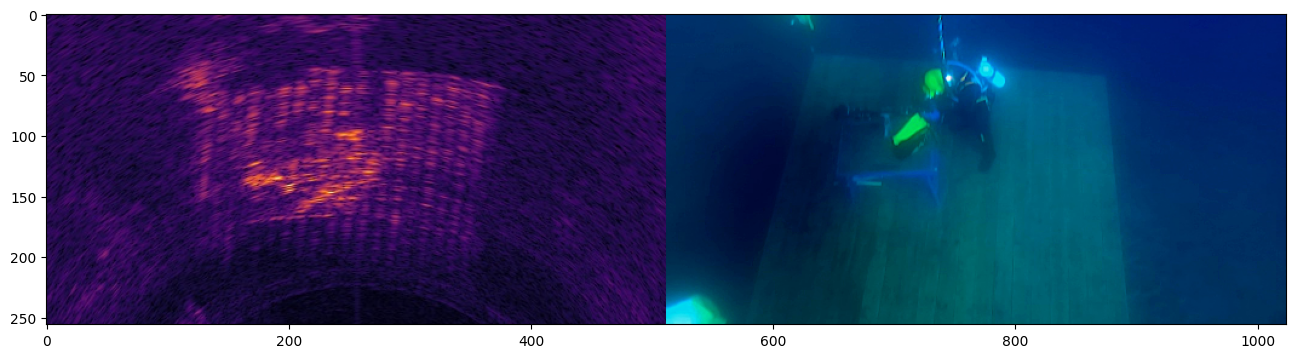

In [18]:
image_file = "/content/BTS23/{}/test-data/0-00000139.png".format(dataset)
image = tf.io.read_file(image_file)
if image_file[-3:]=="png":
  image = tf.io.decode_png(image)
elif image_file[-3:]=="jpg":
  image = tf.io.decode_jpeg(image)

w = tf.shape(image)[1] // 3
images =[]
for i in range(3):
    images.append(tf.cast(image[:, i * w : (i + 1) * w, :], tf.float32))

camera = images[0]
sonar = images[2]

plt.figure(figsize=(16,5))
plt.imshow(np.hstack((sonar.numpy()/255,camera.numpy()/255)))

In [19]:
def normalize_inputs(x):
  """ Normalize a list of 8-bit images to the range of [-1,1]
  """
  normalized = []
  for img in x:
    normalized.append((img / 127.5) - 1)
  return normalized

def darken(image, d: int = 0.5):
  dark = (1-d)*image
  return dark

def blur(image, d: int = 0.5):
  var = 10 * d # variance
  k = int(np.ceil(100 * d) // 2 * 2 + 1)
  kernel = (k,k) # kernel
  blurred = cv2.GaussianBlur(src=image.numpy(), ksize=kernel, sigmaX=var, sigmaY=var) # gaussian blur
  return blurred

d = 0.5
dark = darken(camera, d)
dark = blur(dark, d)

images = normalize_inputs([camera, dark, sonar])
camera, dark, sonar = images

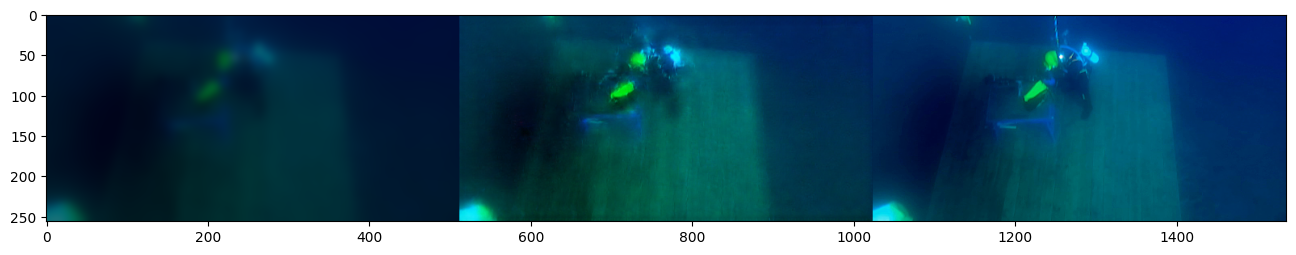

In [20]:
prediction = generator([dark[None,:,:,:], sonar[None,:,:,:]], training=True)
pred = prediction[0].numpy()

stacked = np.hstack((dark,pred,camera))
plt.figure(figsize=(16,5))
plt.imshow(stacked*0.5+0.5)